In [1]:
from pyronn.ct_reconstruction.helpers.filters import filters
from pyronn.ct_reconstruction.layers.backprojection_3d import ConeBackProjection3D

import numpy as np
import torch
from pyronn.ct_reconstruction.geometry.geometry import Geometry
from pyronn.ct_reconstruction.helpers.trajectories.circular_trajectory import (
    circular_trajectory_3d,
)

In [2]:
voxel_per_mm = 10
projs_rows = 972
projs_cols = 768

volume_size = 501
volume_shape = (volume_size, volume_size, volume_size)
volume_spacing = (1 / voxel_per_mm, 1 / voxel_per_mm, 1 / voxel_per_mm)

# Detector Parameters:
detector_shape = (projs_rows, projs_cols)
detector_spacing = (0.1496, 0.1496)

# Trajectory Parameters:
number_of_projections = 360
angular_range = 2 * np.pi

sdd = 199.006195
sid = 66.001404

# create Geometry class
geometry = Geometry()
geometry.init_from_parameters(
    volume_shape=volume_shape,
    volume_spacing=volume_spacing,
    detector_shape=detector_shape,
    detector_spacing=detector_spacing,
    number_of_projections=number_of_projections,
    angular_range=angular_range,
    trajectory=circular_trajectory_3d,
    source_isocenter_distance=sid,
    source_detector_distance=sdd,
)


In [1]:
# put batch_0.pth in the same folder as this script
# download from https://drive.google.com/file/d/1G6_Jshp2PWs8jD-7ky_aS8y7TSTnNoeo/view?usp=sharing

path = r"batch_0.pth"

In [5]:
dataset = torch.load(path)

In [13]:
import matplotlib.pyplot as plt

sample_index = np.random.randint(len(dataset))
volume_sample, sinogram_sample = dataset[sample_index]

# Convert the tensors back to numpy arrays for visualization
volume_sample_np = volume_sample.cpu().numpy().squeeze()
sinogram_sample_np = sinogram_sample.cpu().numpy().squeeze()

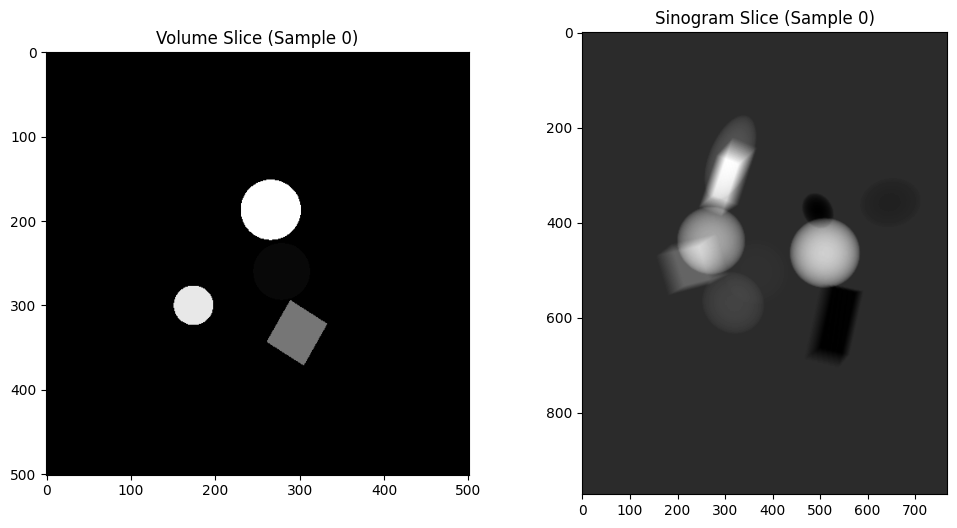

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot a slice of the volume
axs[0].imshow(volume_sample_np[volume_sample_np.shape[0] // 2], cmap='gray')
axs[0].set_title(f'Volume Slice (Sample {sample_index})')

# Plot a slice of the sinogram
axs[1].imshow(sinogram_sample_np[sinogram_sample_np.shape[0] // 2], cmap='gray')
axs[1].set_title(f'Sinogram Slice (Sample {sample_index})')

plt.show()

In [18]:
reco_filter = torch.tensor(
    filters.ram_lak_3D(
        geometry.detector_shape,
        geometry.detector_spacing,
        geometry.number_of_projections,
    ),
    dtype=torch.float32,
).cuda()

x = torch.fft.fft(sinogram_sample.cuda(), dim=-1, norm="ortho")
x = torch.multiply(x, reco_filter)
x = torch.fft.ifft(x, dim=-1, norm="ortho").real

reco = ConeBackProjection3D(hardware_interp=True).forward(
    x.contiguous(), **geometry
)
reco = reco.cpu().numpy()



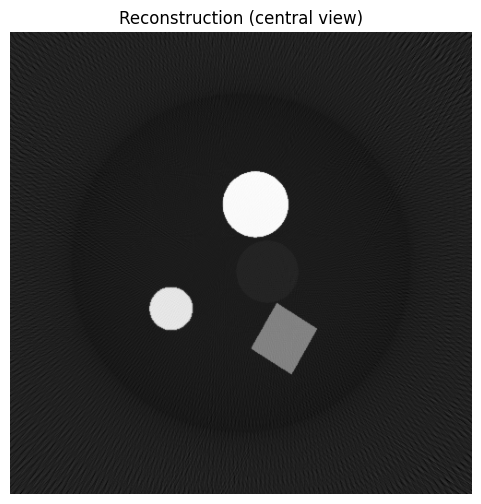

In [19]:
plt.figure(figsize=(6, 6))
plt.imshow(np.squeeze(reco)[volume_shape[0] // 2], cmap="gray")
plt.axis("off")
plt.title("Reconstruction (central view)")
plt.show()